# 1- Import Libraries & Setup Kernel

In [1]:
# Librerías de Dataset y procesamiento
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Librerías para plotear
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Configuración de Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Librerías ML 
from sklearn.cluster import KMeans

# 2- Import & Explore


In [2]:
# Crear un DataFrame llamado "data" para importar el CSV
data = pd.read_csv('../data/OnlineRetail-02.csv')

# Convertir InvoiceDate a formato fecha
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [3]:
data.head()

,CustomerID,Country,InvoiceNo,InvoiceDate,Description,Quantity,UnitPrice,TotalPrice,FirstInvoice,InvoiceYear,InvoiceMonth,InvoiceWeekYear,InvoiceDayYear,InvoiceDayWeek,InvoiceHour,InvoiceTimestamp
0,17850.0,United Kingdom,536365,2010-12-01 08:26:00,white hanging heart t-light holder,6,2.55,15.30,1,2010,12,48,335,2,8,1291188360
1,17850.0,United Kingdom,536365,2010-12-01 08:26:00,white metal lantern,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360
2,17850.0,United Kingdom,536365,2010-12-01 08:26:00,cream cupid hearts coat hanger,8,2.75,22.00,1,2010,12,48,335,2,8,1291188360
3,17850.0,United Kingdom,536365,2010-12-01 08:26:00,knitted union flag hot water bottle,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360
4,17850.0,United Kingdom,536365,2010-12-01 08:26:00,red woolly hottie white heart.,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360


# 3- Amount of New Customers by Months

In [4]:
customers_finvoice = data[data.InvoiceYear == 2011].groupby(['InvoiceMonth', 'FirstInvoice']).CustomerID.agg(['nunique']).reset_index()

new_c = customers_finvoice[customers_finvoice.FirstInvoice == 1]
old_c = customers_finvoice[customers_finvoice.FirstInvoice == 0]

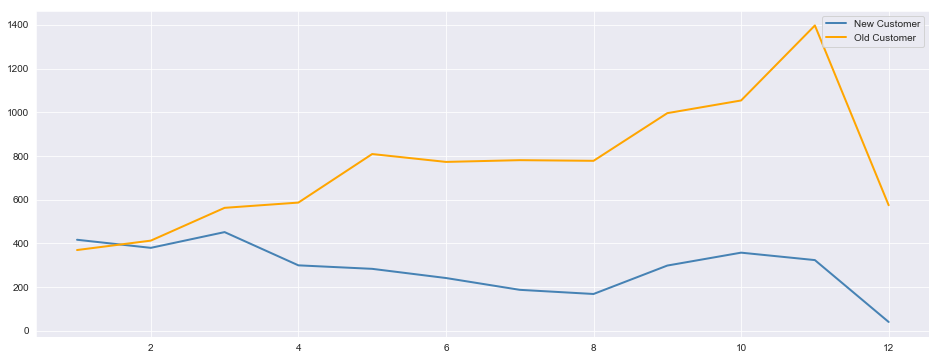

In [5]:
# data['InvoiceYearDAY'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.week)

# insights = pd.pivot_table(data, index=['InvoiceYear','InvoiceYearDAY','FirstInvoice'], 
#                           values=['TotalPrice'], aggfunc={'TotalPrice': np.sum}).reset_index()

plt.figure(figsize=(16, 6))
plt.plot('InvoiceMonth', 'nunique', label='New Customer', 
         data=new_c, color='steelblue', linewidth=2)
plt.plot('InvoiceMonth', 'nunique', label='Old Customer', 
         data=old_c, color='orange', linewidth=2)

plt.legend(loc='upper right')
plt.show()



# 4- RFM Clulsters

In [6]:
# Make a DF with the last purchase date for each customer
df_customers = data.groupby('CustomerID').InvoiceDate.max().reset_index()
df_customers.columns = ['CustomerID','LastPurchaseDate']

# Calculate inactivity days for each CustomerID
df_customers['Recency'] = (df_customers.LastPurchaseDate.max() - df_customers.LastPurchaseDate).dt.days

In [7]:
model_df = data.groupby('CustomerID').InvoiceDate.min().reset_index()
model_df.columns = ['CustomerID','FirstPurchaseDate']

#Amount of Invoices
model_invoices = data.groupby(['CustomerID','InvoiceNo', 'InvoiceDate']).TotalPrice.agg(['sum']).reset_index()
model_invoices.columns = ['CustomerID','InvoiceNo', 'InvoiceDate', 'Revenue']

model_invoices.head()

,CustomerID,InvoiceNo,InvoiceDate,Revenue
0,12346.0,541431,2011-01-18 10:01:00,77183.60
1,12347.0,537626,2010-12-07 14:57:00,711.79
2,12347.0,542237,2011-01-26 14:30:00,475.39
3,12347.0,549222,2011-04-07 10:43:00,636.25
4,12347.0,556201,2011-06-09 13:01:00,382.52


In [8]:
# Contar dias entre invoices
list_invoices = model_invoices.InvoiceNo
model_invoices['days_firstInvoice'] = 0

for invoice in list_invoices:
    date_invoices = model_invoices.InvoiceDate[model_invoices.InvoiceNo == invoice]
    get_user = float(model_invoices.CustomerID[model_invoices.InvoiceNo == invoice].unique())
    first_purchase = model_invoices.InvoiceDate[model_invoices.CustomerID == get_user].min()
    days = (date_invoices - first_purchase).dt.days
    model_invoices.days_firstInvoice[model_invoices.InvoiceNo == invoice] = days


C:\Users\Chorch\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Chorch\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


---
# Recency (Final)

Function to get the "Recency value" of  customers by each months, and also invert results to determine that high value as the most valuable

**Formula**: (Fisrt_Invoices_Date + 30 days - Last_Inovice_Date)<br>

In [9]:
def recency_1M(customer):
    day = 30
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)

def recency_2M(customer):
    day = 60
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)    
#     return -((finaldate - (last_invoices + timedelta(days=30))).days)

def recency_3M(customer):
    day = 90
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)
#     return -((finaldate - (last_invoices + timedelta(days=60))).days)


def recency_4M(customer):
    day = 120
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)
#     return -((finaldate - (last_invoices + timedelta(days=90))).days)

model_invoices['Recency_1M'] = model_invoices.CustomerID.apply(recency_1M)
model_invoices['Recency_2M'] = model_invoices.CustomerID.apply(recency_2M)
model_invoices['Recency_3M'] = model_invoices.CustomerID.apply(recency_3M)
model_invoices['Recency_4M'] = model_invoices.CustomerID.apply(recency_4M)

---
# Frequency (Final)

Function to get the "Frequency value" of  customers by each months, and also invert results to determine that high value as the most valuable.

**Formula**: -(Days / Amonut of Invoices)

In [10]:
def frequency_1M(customer):
    day = 30
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    if n_invoices == 0:
        return -(round(day / 1))
    else:
        return -(round(day / n_invoices))

def frequency_2M(customer):
    day = 60
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 30)])
    if n_invoices == 0:
        return -(round((day - 30) / 1))
    else:
        return -(round((day - 30) / n_invoices))
    
def frequency_3M(customer):
    day = 90
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 60)])
    if n_invoices == 0:
        return -(round((day - 60) / 1))
    else:
        return -(round((day - 60) / n_invoices))
    
def frequency_4M(customer):
    day = 120
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 90)])
    if n_invoices == 0:
        return -(round((day - 90) / 1))
    else:
        return -(round((day - 90) / n_invoices))
    
model_invoices['Frequency_1M'] = model_invoices.CustomerID.apply(frequency_1M)
model_invoices['Frequency_2M'] = model_invoices.CustomerID.apply(frequency_2M)
model_invoices['Frequency_3M'] = model_invoices.CustomerID.apply(frequency_3M)
model_invoices['Frequency_4M'] = model_invoices.CustomerID.apply(frequency_4M)

---
# Monetary (Final)

Function to get the sum of "Monetary value" of customers by each months.

**Result**: Revenue by each month

In [11]:
def monetary_1M(customer):
    day = 30
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_2M(customer):
    day = 60
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 30)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_3M(customer):
    day = 90
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 60)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_rev(customer):
    day = 180
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

model_invoices['Monetary_1M'] = model_invoices.CustomerID.apply(monetary_1M)
model_invoices['Monetary_2M'] = model_invoices.CustomerID.apply(monetary_2M)
model_invoices['Monetary_3M'] = model_invoices.CustomerID.apply(monetary_3M)
model_invoices['Revenue'] = model_invoices.CustomerID.apply(monetary_rev)


In [12]:
model_invoices.head()

,CustomerID,InvoiceNo,InvoiceDate,Revenue,days_firstInvoice,Recency_1M,Recency_2M,Recency_3M,Recency_4M,Frequency_1M,Frequency_2M,Frequency_3M,Frequency_4M,Monetary_1M,Monetary_2M,Monetary_3M
0,12346.0,541431,2011-01-18 10:01:00,77184,0,-30,-60,-90,-120,-30,-30,-30,-30,77184,0,0
1,12347.0,537626,2010-12-07 14:57:00,1823,0,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
2,12347.0,542237,2011-01-26 14:30:00,1823,49,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
3,12347.0,549222,2011-04-07 10:43:00,1823,120,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
4,12347.0,556201,2011-06-09 13:01:00,1823,183,-30,-10,-40,1,-30,-30,-30,-30,712,475,0


In [69]:
# Crear la base del modelo
rfm_model = pd.pivot_table(
    model_invoices, index='CustomerID', values=['Recency_1M', 'Recency_2M', 'Recency_3M', 'Frequency_1M', 
                                                'Frequency_2M', 'Frequency_3M', 'Monetary_1M', 'Monetary_2M', 
                                                'Monetary_3M','Revenue']).reset_index()

rfm_model.head()

,CustomerID,Frequency_1M,Frequency_2M,Frequency_3M,Monetary_1M,Monetary_2M,Monetary_3M,Recency_1M,Recency_2M,Recency_3M,Revenue
0,12346.0,-30,-30,-30,77184,0,0,-30,-60,-90,77184
1,12347.0,-30,-30,-30,712,475,0,-30,-10,-40,1823
2,12348.0,-30,-30,-30,893,227,0,-30,-20,-50,1487
3,12349.0,-30,-30,-30,1758,0,0,-30,-60,-90,1758
4,12350.0,-30,-30,-30,334,0,0,-30,-60,-90,334


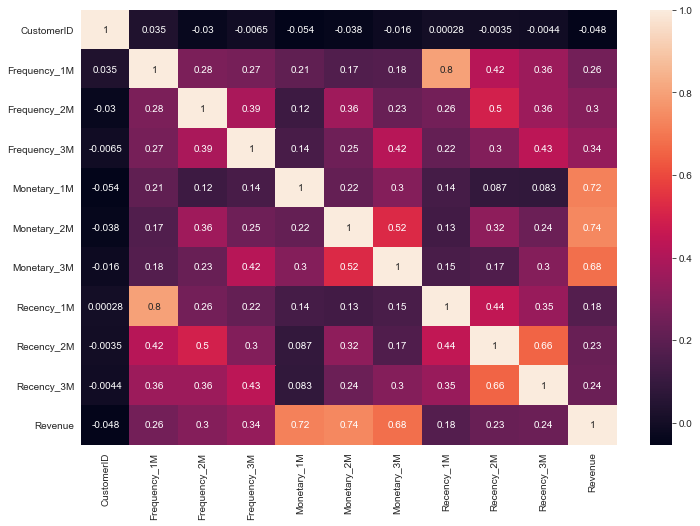

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(rfm_model.corr(), annot=True)
plt.show()

In [71]:
# Agregar Revenue

# customer_rev = data.groupby(['CustomerID']).TotalPrice.agg(['sum']).reset_index()
# customer_rev.columns = ['CustomerID', 'Revenue']

# customer_rev.head()

---
# Dummies productos

In [72]:
# Dummies de productos
dummy_product = pd.pivot_table(data, index='CustomerID', values=['Quantity'], columns='Description').reset_index()

In [73]:
products = dummy_product.Quantity
ids = dummy_product.CustomerID

dummy_product = pd.merge(ids, products, left_index=True, right_index=True)
dummy_product = dummy_product.fillna(0)

dummy_product.shape

(4339, 3878)

In [74]:
# total = dummy_product.isin([0]).sum().reset_index()
# total.columns = ['Products', 'Amount']
# total = total.sort_values(by='Amount')

# dummy_colunms = list(total.Products[:1500])
# dummy_product = dummy_product[dummy_colunms]
# dummy_product.shape

---

# Final Dataset

In [75]:
# WHIT DUMMIES
df_model_f = pd.merge(rfm_model, dummy_product, on='CustomerID')
df_model_f.head()


# WHIT -out DUMMIES
# df_model_f = pd.merge(rfm_model, customer_rev, on='CustomerID')

# df_model_predictor
# dummy_prod
# customer_rev

,CustomerID,Frequency_1M,Frequency_2M,Frequency_3M,Monetary_1M,Monetary_2M,Monetary_3M,Recency_1M,Recency_2M,Recency_3M,Revenue,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,i love london mini rucksack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,trellis coat rack,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 hanging eggs hand painted,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube posy,12 pencils tall tube red retrospot,12 pencils tall tube skulls,12 pencils tall tube woodland,12 pink hen+chicks in basket,12 pink rose peg place settings,12 red rose peg place settings,15 pink fluffy chicks in box,15cm christmas glass ball 20 lights,16 pc cutlery set pantry design,16 piece cutlery set pantry design,18pc wooden cutlery set disposable,2 daisies hair comb,2 picture book eggs easter bunny,2 picture book eggs easter chicks,2 picture book eggs easter ducks,20 dolly pegs retrospot,200 bendy skull straws,200 red + white bendy straws,3 birds canvas screen,3 black cats w hearts blank card,3 drawer antique white wood cabinet,3 gardenia morris boxed candles,3 hearts hanging decoration rustic,3 hook hanger magic garden,3 hook photo shelf antique white,3 piece spaceboy cookie cutter set,3 pink hen+chicks in basket,3 raffia ribbons 50's christmas,3 raffia ribbons vintage christmas,3 rose morris boxed candles,3 stripey mice feltcraft,3 tier cake tin green and cream,3 tier cake tin red and cream,3 tier sweetheart garden shelf,3 traditional biscuit cutters set,3 traditional cookie cutters set,3 white choc morris boxed candles,3 wick christmas briar candle,36 doilies dolly girl,36 doilies vintage christmas,36 foil heart cake cases,36 foil star cake cases,36 pencils tube posy,36 pencils tube red retrospot,36 pencils tube skulls,36 pencils tube woodland,3d christmas stamps stickers,3d dog picture playing cards,3d hearts honeycomb paper garland,3d sheet of cat stickers,3d sheet of dog stickers,3d traditional christmas stickers,3d vintage christmas stickers,4 blue dinner candles silver flock,4 burgundy wine dinner candles,4 ivory dinner candles silver flock,4 lavender botanical dinner candles,4 lily botanical dinner candles,4 pear botanical dinner candles,4 pink dinner candle silver flock,4 pink flock christmas balls,4 rose pink dinner candles,4 sky blue dinner candles,4 traditional spinning tops,4 vanilla botanical candles,4 wildflower botanical candles,5 hook hanger magic toadstool,5 hook hanger red magic toadstool,5 strand glass necklace amber,5 strand glass necklace amethyst,5 strand glass necklace black,5 strand glass necklace crystal,50's christmas paper gift bag,50cm metal string with 7 clips,6 chocolate love heart t-lights,6 egg house painted wood,6 gift tags 50's christmas,6 gift tags vintage christmas,6 ribbons elegant christmas,6 ribbons empire,6 ribbons rustic charm,6 ribbons shimmering pinks,6 rocket balloons,60 cake cases dolly girl design,60 cake cases vintage christmas,60 gold and silver fairy cake cases,60 teatime fairy cake cases,6pc wood plate set disposable,70's alphabet wall art,72 cake cases vintage christmas,72 sweetheart fairy cake cases,75 black petit four cases,75 green fairy cake cases,75 green petit four cases,a pretty thank you card,a4 wall tidy blue office,a4 wall tidy red flowers,abc treasure book box,abstract circle journal,abstract circles pocket book,abstract circles sketchbook,acrylic geometric lamp,"acrylic hanging jewel,blue","acrylic hanging jewel,pink","acrylic jewel angel,pink","acrylic jewel icicle, blue","acrylic jewel icicle, pink","acrylic jewel snowflake, pink","acrylic jewel snowflake,pink",adult apron apple delight,advent calendar gingham sack,afghan sl

In [76]:
def Q_bins_more(x):
    '''
    Function to create bins by Quartiles
    Function can be used, when the interval most higher 
    correspond with the value more higher.
    '''
    quartile = x.quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])
    return pd.cut(np.array(x), quartile, labels=[1, 2, 3, 4, 5, 6])

In [77]:
df_model_f['MonetaryBins'] = Q_bins_more(df_model_f.Revenue)
df_model_f['MonetaryBins'] = df_model_f['MonetaryBins'].fillna(value=1)

In [78]:
# Create correlation matrix
corr_matrix = df_model_f.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(len(to_drop),'\n', to_drop)

361 
 ['3 traditional cookie cutters  set', 'amber glass/shell/pearl necklace', 'angel decoration painted zinc ', 'ass col circle mobile ', 'assorted circular mobile', 'assorted easter decorations  bells', 'baking mould toffee cup  chocolate', 'bird on branch canvas screen', 'black 3 bead drop earrings', 'black and white dog bowl', 'blue bunny easter egg basket', 'blue monte carlo handbag', 'blue tv tray table ', 'blue victorian fabric oval box', 'blue/green shell necklace w pendant', 'botanical gardens wall clock ', 'bread bin, diner style, mint', 'brocante coat rack', 'buffalo bill wall art ', 'cast iron hook garden fork', 'cast iron hook garden trowel', 'cat and bird wall art', 'cd wall tidy red flowers', 'childrens cutlery polkadot pink', 'childs garden brush pink', 'childs garden rake pink', 'childs garden spade pink', 'classic bicycle clips ', 'classic chrome bicycle bell ', 'classic diamante earrings jet', 'classic diamante necklace jet', 'coffee mug blue paisley design', 'coffe

In [79]:
# Drop features 
df_model_f = df_model_f.drop(df_model_f[to_drop], axis=1)

In [80]:
# Crear Dataset con Train-Test y Predicted

# Convertir InvoiceDate a formato fecha
# data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

cut_pred = '2011-09-01'
fin_pred = '2011-09-30'

pred_customers = model_df.CustomerID[(model_df.FirstPurchaseDate >= pd.to_datetime(cut_pred)) & (model_df.FirstPurchaseDate <= pd.to_datetime(fin_pred))]

cut_test = '2011-06-01'
fin_test = '2011-08-31'

test_customers = model_df.CustomerID[(model_df.FirstPurchaseDate >= pd.to_datetime(cut_test)) & (model_df.FirstPurchaseDate <= pd.to_datetime(fin_test))]

cut_train = '2011-05-31'

train_customers = model_df.CustomerID[(model_df.FirstPurchaseDate <= pd.to_datetime(cut_train))]

print('Train:', len(train_customers), '\nTest:', len(test_customers), '\nPredict:', len(pred_customers))


Train: 2708 
Test: 594 
Predict: 287


In [83]:
# Define Train Test
df_train = df_model_f[df_model_f.CustomerID.isin(train_customers)]
df_test = df_model_f[df_model_f.CustomerID.isin(test_customers)]
df_predict = df_model_f[df_model_f.CustomerID.isin(pred_customers)]


# DATA
X_train = df_train.drop(columns=['MonetaryBins', 'Revenue'])
# Target
y_train = df_train['MonetaryBins']

# DATA
X_test = df_test.drop(columns=['MonetaryBins', 'Revenue'])
# Target
y_test = df_test['MonetaryBins']


In [84]:
df_model_f.head()

,CustomerID,Frequency_1M,Frequency_2M,Frequency_3M,Monetary_1M,Monetary_2M,Monetary_3M,Recency_1M,Recency_2M,Recency_3M,Revenue,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,i love london mini rucksack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,trellis coat rack,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 hanging eggs hand painted,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube posy,12 pencils tall tube red retrospot,12 pencils tall tube skulls,12 pencils tall tube woodland,12 pink hen+chicks in basket,12 pink rose peg place settings,12 red rose peg place settings,15 pink fluffy chicks in box,15cm christmas glass ball 20 lights,16 pc cutlery set pantry design,16 piece cutlery set pantry design,18pc wooden cutlery set disposable,2 daisies hair comb,2 picture book eggs easter bunny,2 picture book eggs easter chicks,2 picture book eggs easter ducks,20 dolly pegs retrospot,200 bendy skull straws,200 red + white bendy straws,3 birds canvas screen,3 black cats w hearts blank card,3 drawer antique white wood cabinet,3 gardenia morris boxed candles,3 hearts hanging decoration rustic,3 hook hanger magic garden,3 hook photo shelf antique white,3 piece spaceboy cookie cutter set,3 pink hen+chicks in basket,3 raffia ribbons 50's christmas,3 raffia ribbons vintage christmas,3 rose morris boxed candles,3 stripey mice feltcraft,3 tier cake tin green and cream,3 tier cake tin red and cream,3 tier sweetheart garden shelf,3 traditional biscuit cutters set,3 white choc morris boxed candles,3 wick christmas briar candle,36 doilies dolly girl,36 doilies vintage christmas,36 foil heart cake cases,36 foil star cake cases,36 pencils tube posy,36 pencils tube red retrospot,36 pencils tube skulls,36 pencils tube woodland,3d christmas stamps stickers,3d dog picture playing cards,3d hearts honeycomb paper garland,3d sheet of cat stickers,3d sheet of dog stickers,3d traditional christmas stickers,3d vintage christmas stickers,4 blue dinner candles silver flock,4 burgundy wine dinner candles,4 ivory dinner candles silver flock,4 lavender botanical dinner candles,4 lily botanical dinner candles,4 pear botanical dinner candles,4 pink dinner candle silver flock,4 pink flock christmas balls,4 rose pink dinner candles,4 sky blue dinner candles,4 traditional spinning tops,4 vanilla botanical candles,4 wildflower botanical candles,5 hook hanger magic toadstool,5 hook hanger red magic toadstool,5 strand glass necklace amber,5 strand glass necklace amethyst,5 strand glass necklace black,5 strand glass necklace crystal,50's christmas paper gift bag,50cm metal string with 7 clips,6 chocolate love heart t-lights,6 egg house painted wood,6 gift tags 50's christmas,6 gift tags vintage christmas,6 ribbons elegant christmas,6 ribbons empire,6 ribbons rustic charm,6 ribbons shimmering pinks,6 rocket balloons,60 cake cases dolly girl design,60 cake cases vintage christmas,60 gold and silver fairy cake cases,60 teatime fairy cake cases,6pc wood plate set disposable,70's alphabet wall art,72 cake cases vintage christmas,72 sweetheart fairy cake cases,75 black petit four cases,75 green fairy cake cases,75 green petit four cases,a pretty thank you card,a4 wall tidy blue office,a4 wall tidy red flowers,abc treasure book box,abstract circle journal,abstract circles pocket book,abstract circles sketchbook,acrylic geometric lamp,"acrylic hanging jewel,blue","acrylic hanging jewel,pink","acrylic jewel angel,pink","acrylic jewel icicle, blue","acrylic jewel icicle, pink","acrylic jewel snowflake, pink","acrylic jewel snowflake,pink",adult apron apple delight,advent calendar gingham sack,afghan slipper sock pair,aged glass silver

# Make Model by Week (RandomForestClassifier)

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [86]:
#Grid search for parameter selection for a Random Forest Classifier model
param_grid = {
   'n_estimators': [100, 200, 300],
   'max_features': ['auto','sqrt','log2'],
   'max_depth': [15, 10, 5]
}

In [87]:
#Model creation:
RFC = RandomForestClassifier(n_jobs=-1)
GS = GridSearchCV(RFC, param_grid, cv=5, verbose = 8)

#LAUNCH MODEL:
GS.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=15, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=15, max_features=auto, n_estimators=100, score=0.6617647058823529, total=   4.0s
[CV] max_depth=15, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV]  max_depth=15, max_features=auto, n_estimators=100, score=0.6537753222836096, total=   1.0s
[CV] max_depth=15, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV]  max_depth=15, max_features=auto, n_estimators=100, score=0.6839186691312384, total=   1.1s
[CV] max_depth=15, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  max_depth=15, max_features=auto, n_estimators=100, score=0.6598890942698706, total=   1.1s
[CV] max_depth=15, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s


[CV]  max_depth=15, max_features=auto, n_estimators=100, score=0.5769944341372912, total=   1.1s
[CV] max_depth=15, max_features=auto, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s


[CV]  max_depth=15, max_features=auto, n_estimators=200, score=0.5698529411764706, total=   1.7s
[CV] max_depth=15, max_features=auto, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.5s remaining:    0.0s


[CV]  max_depth=15, max_features=auto, n_estimators=200, score=0.6721915285451197, total=   1.8s
[CV] max_depth=15, max_features=auto, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.6s remaining:    0.0s


[CV]  max_depth=15, max_features=auto, n_estimators=200, score=0.6894639556377079, total=   1.7s
[CV] max_depth=15, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=15, max_features=auto, n_estimators=200, score=0.6654343807763401, total=   1.6s
[CV] max_depth=15, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=15, max_features=auto, n_estimators=200, score=0.6326530612244898, total=   1.6s
[CV] max_depth=15, max_features=auto, n_estimators=300 ...............
[CV]  max_depth=15, max_features=auto, n_estimators=300, score=0.6415441176470589, total=   2.2s
[CV] max_depth=15, max_features=auto, n_estimators=300 ...............
[CV]  max_depth=15, max_features=auto, n_estimators=300, score=0.6721915285451197, total=   2.2s
[CV] max_depth=15, max_features=auto, n_estimators=300 ...............
[CV]  max_depth=15, max_features=auto, n_estimators=300, score=0.6913123844731978, total=   2.2s
[CV] max_depth=15, max_features=auto, n_estimators=300 ........

[CV]  max_depth=10, max_features=auto, n_estimators=300, score=0.6537753222836096, total=   1.5s
[CV] max_depth=10, max_features=auto, n_estimators=300 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=300, score=0.6617375231053605, total=   1.5s
[CV] max_depth=10, max_features=auto, n_estimators=300 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=300, score=0.6487985212569316, total=   1.6s
[CV] max_depth=10, max_features=auto, n_estimators=300 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=300, score=0.647495361781076, total=   1.6s
[CV] max_depth=10, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=100, score=0.6268382352941176, total=   0.8s
[CV] max_depth=10, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=100, score=0.6537753222836096, total=   0.8s
[CV] max_depth=10, max_features=sqrt, n_estimators=100 .........

[CV]  max_depth=5, max_features=sqrt, n_estimators=100, score=0.5496323529411765, total=   0.5s
[CV] max_depth=5, max_features=sqrt, n_estimators=100 ................
[CV]  max_depth=5, max_features=sqrt, n_estimators=100, score=0.58195211786372, total=   0.6s
[CV] max_depth=5, max_features=sqrt, n_estimators=100 ................
[CV]  max_depth=5, max_features=sqrt, n_estimators=100, score=0.5841035120147874, total=   0.5s
[CV] max_depth=5, max_features=sqrt, n_estimators=100 ................
[CV]  max_depth=5, max_features=sqrt, n_estimators=100, score=0.5970425138632163, total=   0.5s
[CV] max_depth=5, max_features=sqrt, n_estimators=100 ................
[CV]  max_depth=5, max_features=sqrt, n_estimators=100, score=0.6178107606679035, total=   0.5s
[CV] max_depth=5, max_features=sqrt, n_estimators=200 ................
[CV]  max_depth=5, max_features=sqrt, n_estimators=200, score=0.53125, total=   0.8s
[CV] max_depth=5, max_features=sqrt, n_estimators=200 ................
[CV]  max_d

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [15, 10, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=8)

In [88]:
GS.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}

In [67]:
#With the best parameters, we create the final model with the train dataset:
RFR = RandomForestClassifier(max_depth = 15, max_features='auto', n_estimators=300)
RFR.fit(X_train, y_train)

#Prediction of the test dataset:
y_train_pred = RFR.predict(X_train)
y_pred = RFR.predict(X_test)

#We check scores with train:
r2 = r2_score(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print ('TRAIN MODEL METRICS:')
print('The R2 score is: ' + str(r2))
print('The MAE score is: ' + str(mae))

#We check scores with test:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print ('TEST MODEL METRICS:')
print('The R2 score is: ' + str(r2))
print('The MAE score is: ' + str(mae))

TRAIN MODEL METRICS:
The R2 score is: 0.9749900089936625
The MAE score is: 0.022156573116691284
TEST MODEL METRICS:
The R2 score is: 0.8538363742717828
The MAE score is: 0.13468013468013468


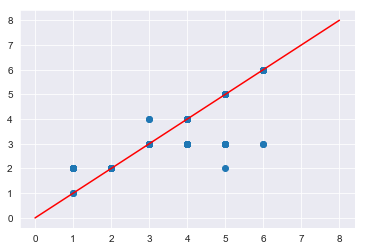

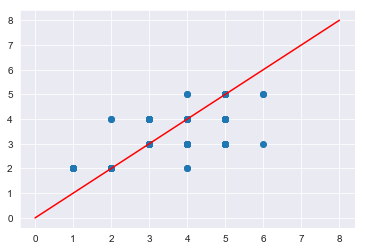

In [68]:
y_pred = RFR.predict(X_train)
plt.scatter(y_train, y_pred)
plt.plot([0, 8], [0, 8], color='red')
# plt.xlim(0, 70000)
# plt.ylim(0, 70000)
plt.show()

y_pred = RFR.predict(X_test)
plt.scatter(y_test, y_pred)
plt.plot([0, 8], [0, 8], color='red')
# plt.xlim(0, 70000)
# plt.ylim(0, 70000)
plt.show()



In [ ]:
# ROC